In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy
import scipy.io
import h5py

def get_groups_and_return_genes_and_species(taxa_level):

    #Import packages
    import pandas as pd
    import numpy as np 
    

    #Read in used files 
    ortho_groups_to_genes = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/odb10v1_OG2genes.tab',sep = '\t',names = 
        ['Group ID','Gene ID'])
    ortho_groups_to_taxa = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/odb10v1_OGs.tab', sep = '\t',names = 
        ['Group ID','taxa_ID','Group Name'])
    ortho_genes_to_species = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/odb10v1_genes.tab', sep = '\t',names = 
        ['Gene ID','species_ID','Protein seq','synonyms','Uniprot','Ensembl','NCBI','Description'])
    indexed_ortho_genes = ortho_genes_to_species.set_index('Gene ID')
    coconet_plants = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/tax_report.txt', sep = '\t')
    coconet_plants.drop(['code','|','|.1','|.2','preferred name'],axis = 1,inplace=True)

    # Get the groups 
    ortho_groups_built_on_taxa_lvl = ortho_groups_to_taxa.loc[ortho_groups_to_taxa['taxa_ID'] == taxa_level ]
    ortho_list_taxa_lvl = ortho_groups_built_on_taxa_lvl['Group ID']
    ortho_genes_in_taxa_groups = ortho_groups_to_genes.loc[ortho_groups_to_genes['Group ID'].isin(ortho_list_taxa_lvl.to_list())]

    #Drop Duplicates 
    ortho_genes_in_taxa_groups.drop_duplicates(subset ='Gene ID',inplace=True)
    #Clean Species ID
    ortho_genes_in_taxa_groups['Species ID'] = ortho_genes_in_taxa_groups['Gene ID'].str.partition('_')[0]

    #Drop Species not in CococoNet 
    ortho_genes_in_taxa_cocoplants = ortho_genes_in_taxa_groups.loc[ortho_genes_in_taxa_groups['Species ID'].isin(list(map(str,
        coconet_plants['taxid'].to_list())))]
    #Get Gene and Common Name mapping    
    ortho_genes_in_taxa_cocoplants.merge(right =ortho_genes_to_species[['Gene ID','Uniprot','Ensembl','NCBI']], on = 'Gene ID',how = 'left')   
    coconet_plants.columns =['Common Name', 'Species ID']
    coconet_typed = coconet_plants.astype({'Species ID':'str'})
    ortho_genes_in_taxa_cocoplants.merge(right = coconet_typed, on = 'Species ID',how = 'left' )  

    return ortho_genes_in_taxa_cocoplants


def read_cococonet(file_location):
    import h5py
    net = h5py.File(file_location,'r')
    agg_dataset = net['agg'] 
    row_dataset = net['row']
    col_dataset = net['col']
    row_gene_list = []
    for gene in row_dataset:
        row_gene_list.append(gene.decode('UTF-8'))
    col_gene_list = []
    for gene in col_dataset: 
        col_gene_list.append(gene.decode('UTF-8'))
    net_df = pd.DataFrame(data = agg_dataset[:,:], index = row_gene_list, columns = col_gene_list)
    net.close()
    return net_df

In [2]:
eudicot_groups = get_groups_and_return_genes_and_species(71240)
eudicot_groups

/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-1-ef6763d42218>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ortho_genes_in_taxa_groups.drop_duplicates(subset ='Gene ID',inplace=True)
<ipython-input-1-ef6763d42218>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ortho_genes_in_taxa_groups['Species ID'] = ortho_genes_in_taxa_groups['Gen

,Group ID,Gene ID,Species ID
19314,100004at71240,29760_0:000a7f,29760
19341,100004at71240,3702_0:002244,3702
19342,100004at71240,3711_0:0096e0,3711
19344,100004at71240,3750_0:000894,3750
19345,100004at71240,3750_0:00624e,3750
...,...,...,...
195683137,99991at71240,4097_0:0061df,4097
195683138,99991at71240,4097_0:0071a2,4097
195683139,99991at71240,4097_0:0080b8,4097
195683144,99991at71240,4113_0:00232e,4113


In [3]:
arab_go = h5py.File('/home/passala/Gene_duplication_project/Networks/arabidopsis_gene2go.hdf5','r')
Go_dataset = arab_go['GO']
genes_dataset = arab_go['genes'] 
Go_groups = []
for annot in Go_dataset:
    current_annot = annot.decode('UTF-8')
    Go_groups.append(current_annot)
Gene_groups = []
for genename in genes_dataset:
    cur_gene_name = genename.decode('UTF-8')
    Gene_groups.append(cur_gene_name)
arab_go_matrix = scipy.io.mmread('/home/passala/Gene_duplication_project/Networks/arab_sparse_matrix_full.mtx')
d_arab_go = arab_go_matrix.todense()
panda_arab = pd.DataFrame.sparse.from_spmatrix(data = arab_go_matrix, index = Gene_groups , columns = Go_groups)
panda_arab = panda_arab.drop(index = 'NA')

In [4]:
panda_arab['GO:0002213'].sum()

23.0

In [5]:
arab_go_terms_of_interest = panda_arab.rename(columns = {'GO:0015979':'Photosynthesis','GO:0009909':'Regulation of Flower Development','GO:0006412':'Translation','GO:0043207':'External Stimulus Detection','GO:0006281':'DNA Repair','GO:0048366':'Leaf Development','GO:0005777':'Peroxisome','GO:0002213':'Insect Defense'})


arab_go_terms_of_interest = arab_go_terms_of_interest[['Regulation of Flower Development','External Stimulus Detection','Leaf Development','Insect Defense','Photosynthesis','Translation','Peroxisome','DNA Repair']]


list_of_genes_of_interest = ['Regulation of Flower Development','External Stimulus Detection','Leaf Development','Insect Defense','Photosynthesis','Translation','Peroxisome','DNA Repair']
list_of_eudicots_to_compare = [3711,3880,3750,29760,4097,4081,4113]

In [6]:
tester = pd.DataFrame(arab_go_terms_of_interest['Regulation of Flower Development'].loc[arab_go_terms_of_interest['Regulation of Flower Development'] == 1])
tester = tester.reset_index().drop(columns = 'Regulation of Flower Development')
tester = tester.rename(columns = {'index':'sp2_gene'})
#arab_go_terms_of_interest[arab_go_terms_of_interest['Reproductive Development'] == 1]

In [7]:
def get_fc_sc_for_gene_list(species_id,pd_arab_genes):
    taxa_mapper = pd.read_csv('/home/passala/Gene_duplication_project/Generated_tables/Time Savers/coconet_nm_prio_plant_paths.csv')
    species_path =  taxa_mapper['Path'].loc[taxa_mapper['Taxa ID'] == species_id].to_list()[0]
    species_name =  taxa_mapper['Species'].loc[taxa_mapper['Taxa ID'] == species_id].to_list()[0]
    functional_conservation = pd.read_csv(species_path)
    fc_sc_map = pd_arab_genes.merge(functional_conservation,on = 'sp2_gene',how = 'left')
    fc_sc_map.dropna(inplace = True)
    return fc_sc_map,species_name

In [8]:
test_2,namer = get_fc_sc_for_gene_list(4113,tester)
test_2

FileNotFoundError: [Errno 2] No such file or directory: '/home/passala/Gene_duplication_project/Generated_tables/Time Savers/coconet_nm_prio_plant_paths.csv'

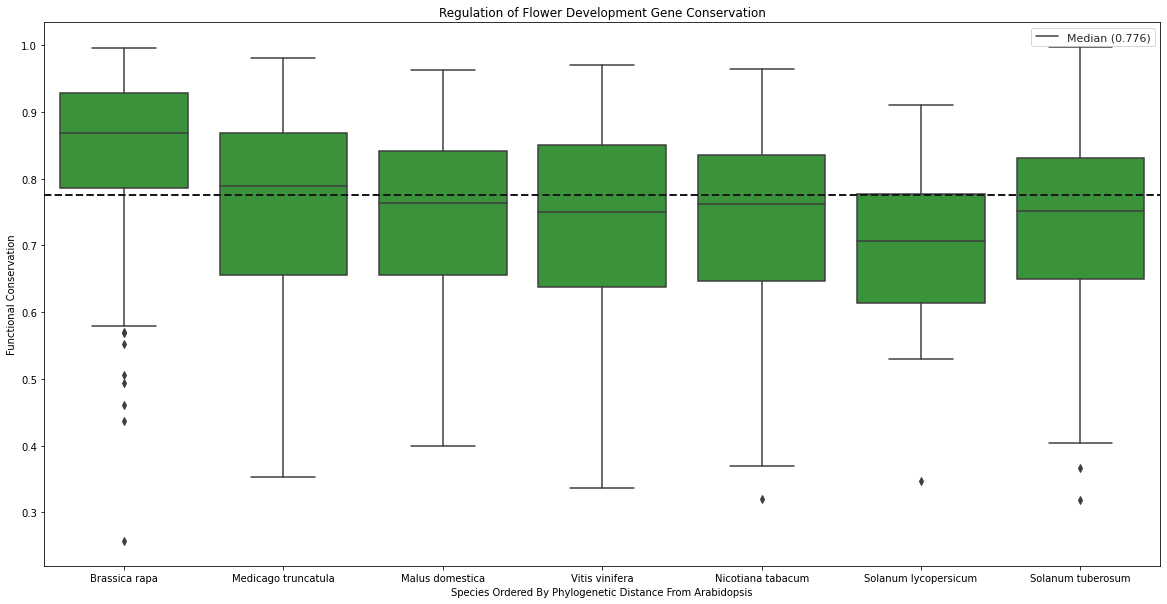

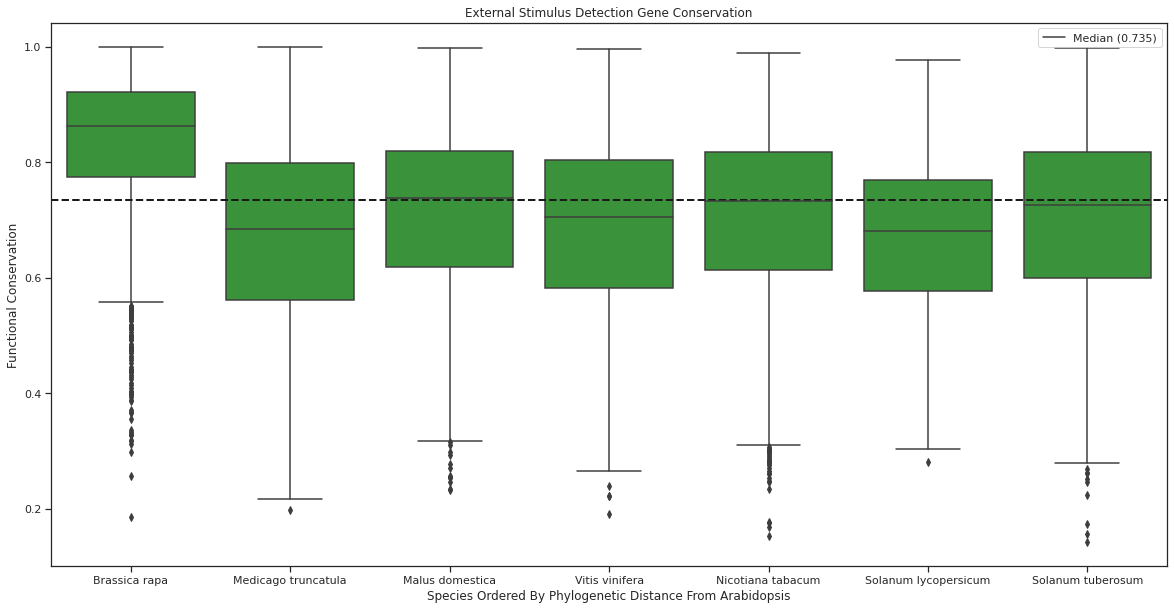

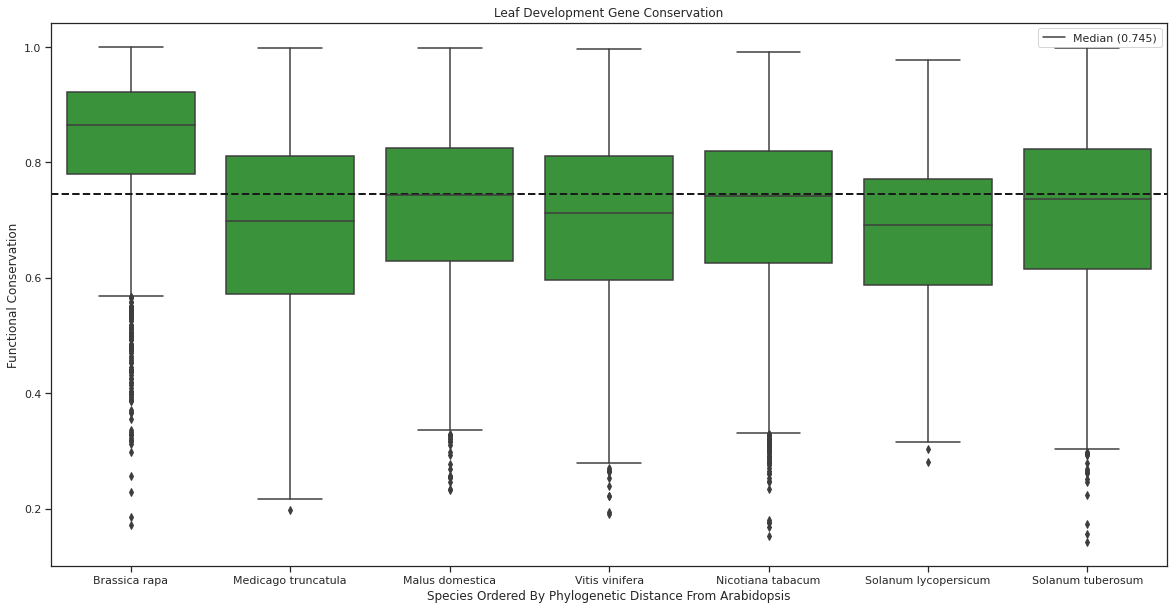

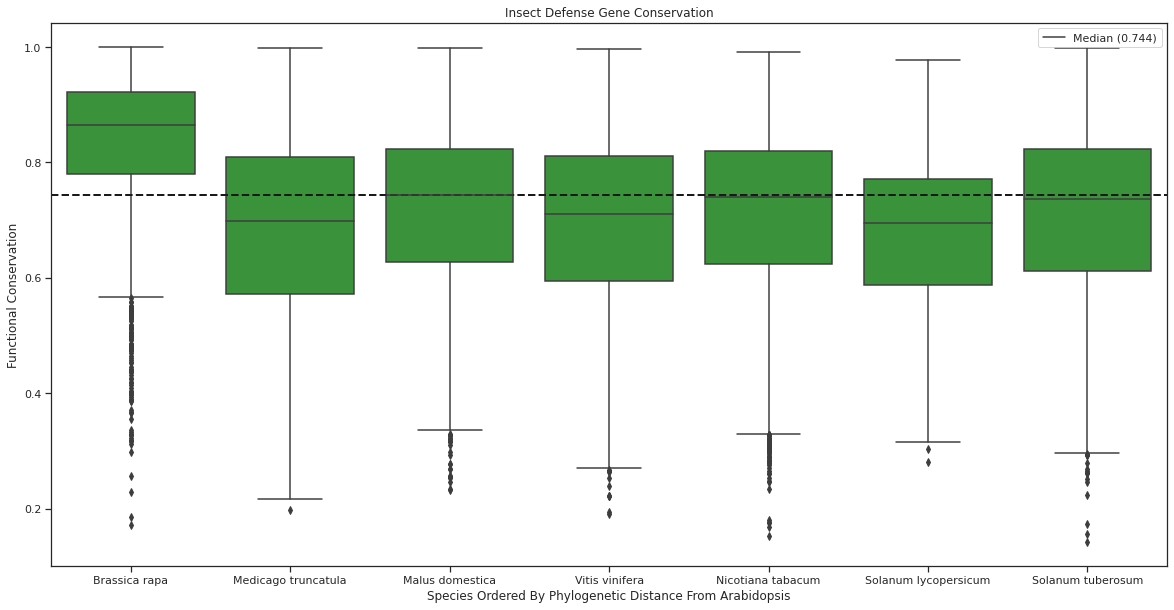

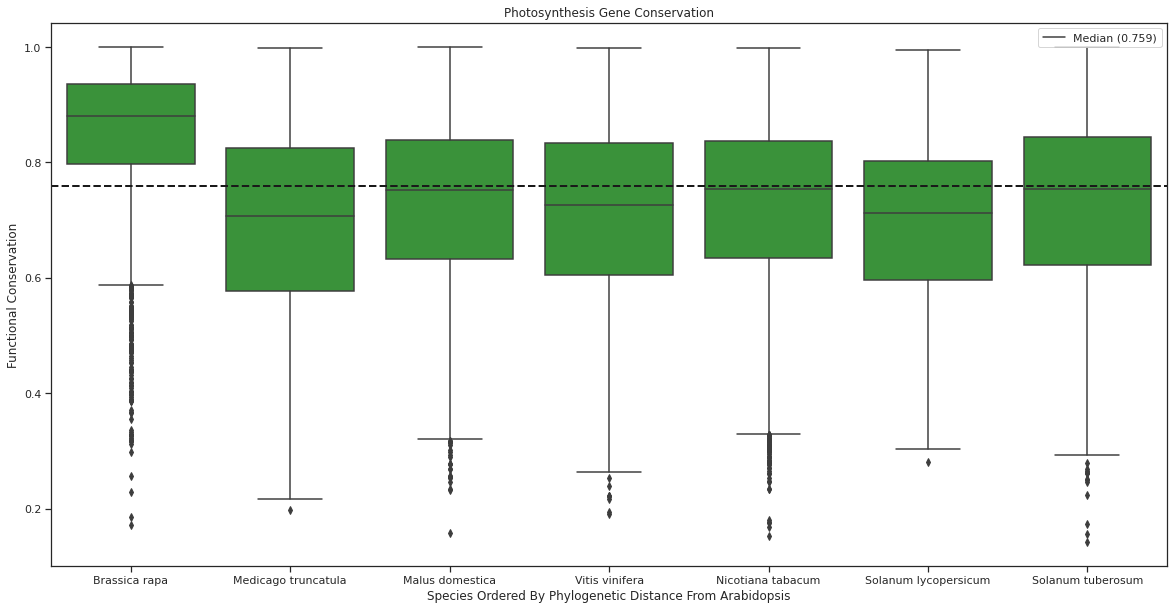

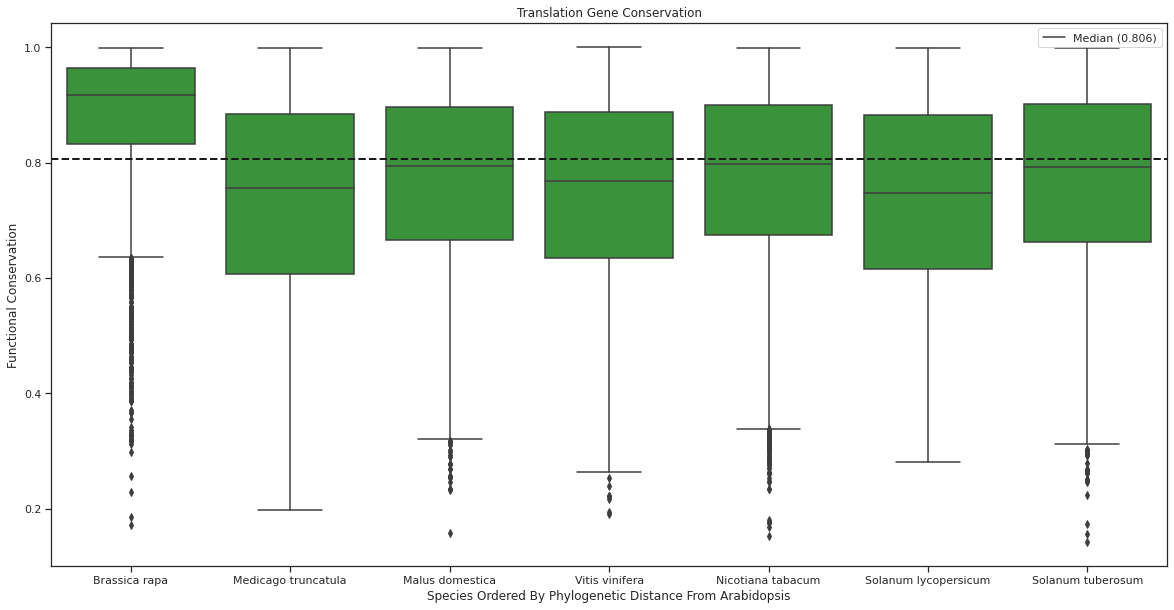

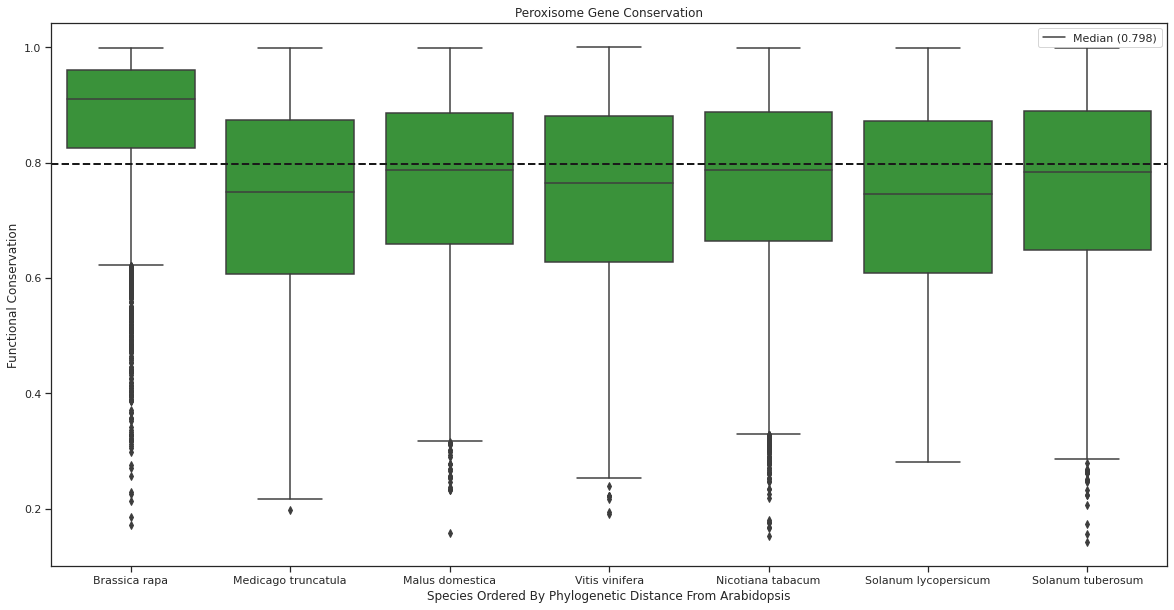

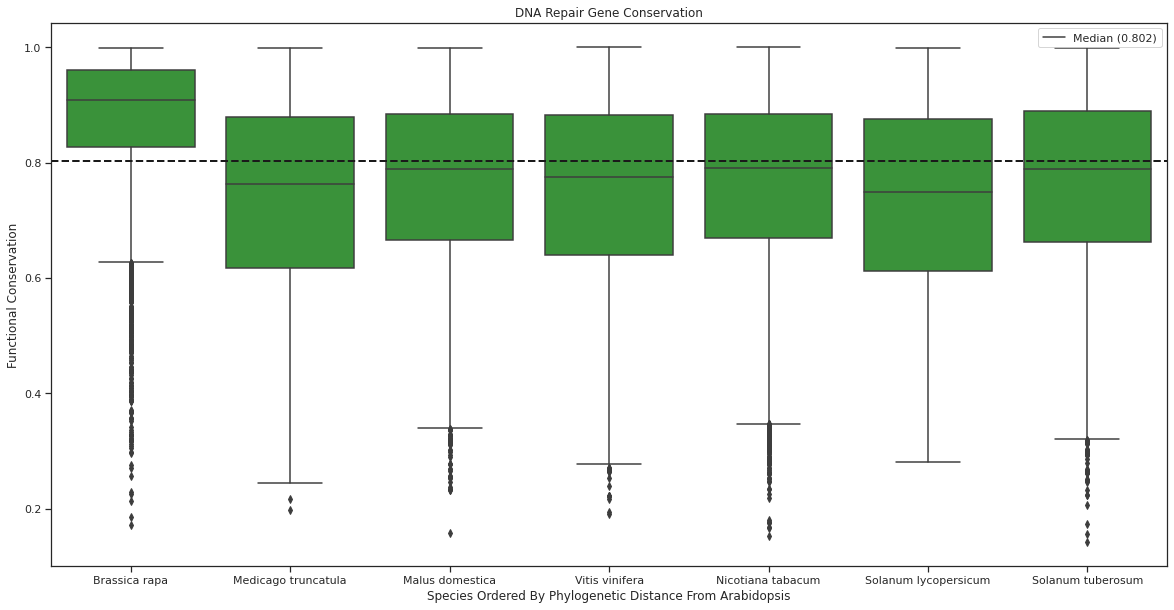

In [10]:
eudicot_divergence = pd.DataFrame(columns = ['Score','Species','Score Type'])
median_fc =[]
for function in list_of_genes_of_interest:
    gene_list = pd.DataFrame(arab_go_terms_of_interest[function].loc[arab_go_terms_of_interest[function] == 1])
    gene_list = gene_list.reset_index().drop(columns = function)
    gene_list = gene_list.rename(columns = {'index':'sp2_gene'})
    eudicot__divergence = pd.DataFrame(columns = ['Score','Species','Score Type'])
    for eudicot in list_of_eudicots_to_compare:
        current_fc_sc,current_name = get_fc_sc_for_gene_list(eudicot,gene_list)
        current_fc_sc['Species'] = current_name
        current_fc= current_fc_sc.drop(columns = ['sp2_gene','sc','sp1_gene'])
        current_fc = current_fc.rename(columns = {'fc':'Score'})
        current_fc['Score Type'] = 'FC'

        eudicot_divergence = eudicot_divergence.append(current_fc,ignore_index = True)
        
        current_sc = current_fc_sc.drop(columns = ['sp2_gene','fc','sp1_gene'])
        current_sc = current_sc.rename(columns = {'sc':'Score'})
        current_sc['Score Type'] = 'SC'

        eudicot_divergence = eudicot_divergence.append(current_sc,ignore_index = True)
    fig, ax = plt.subplots(figsize = (20,10))
    sns.set_theme(style = 'ticks')
    sns.boxplot(ax = ax, y = 'Score',x = 'Species', color = 'tab:green', data = eudicot_divergence.loc[eudicot_divergence['Score Type'].str.match('FC')] )
    plt.ylabel("Functional Conservation")

    current_median_fc = eudicot_divergence.loc[eudicot_divergence['Score Type'].str.match('FC')]['Score'].median()
    current_median_fc = round(current_median_fc,3)
    plt.axhline(current_median_fc,color = 'k',linestyle = 'dashed',linewidth = 2)
    plt.xlabel('Species Ordered By Phylogenetic Distance From Arabidopsis')
    plt.legend([f'Median ({current_median_fc})'])
    plt.title(f'{function} Gene Conservation')
    fig.savefig(f'/home/passala/Gene_duplication_project/Figures/Function_Investigation_Plots/{function}_gene_comparison')
    median_fc.append([function,current_median_fc])


In [11]:
eudicot_divergence

,Score,Species,Score Type
0,0.925621,Brassica rapa,FC
1,0.967905,Brassica rapa,FC
2,0.892532,Brassica rapa,FC
3,0.903501,Brassica rapa,FC
4,0.952545,Brassica rapa,FC
...,...,...,...
67809,0.795533,Solanum tuberosum,SC
67810,0.768165,Solanum tuberosum,SC
67811,0.904458,Solanum tuberosum,SC
67812,0.945180,Solanum tuberosum,SC


In [12]:
median_fc

[['Regulation of Flower Development', 0.776],
 ['External Stimulus Detection', 0.735],
 ['Leaf Development', 0.745],
 ['Insect Defense', 0.744],
 ['Photosynthesis', 0.759],
 ['Translation', 0.806],
 ['Peroxisome', 0.798],
 ['DNA Repair', 0.802]]